# Training Neural Networks with Keras

Welcome to the first practical session of the course! In this session, we will learn how to train neural networks with Keras. We will start with a simple example of a feedforward neural network for classification and then we will study the impact of the initialization of the weights on the convergence of the training algorithm.

Keras is a high-level neural network API, built on top of TensorFlow 2.0. It provides a user-friendly interface to build, train and deploy deep learning models. Keras is designed to be modular, fast and easy to use.

Throughout this course, we will focus on using Keras and TensorFlow for building and training neural networks. However, there are other popular deep learning frameworks such as PyTorch, MXNet, CNTK, etc. that you can also use to build and train neural networks.

In order to use our code on Google Colab, we will need to ensure that any required packages are installed. We will use the following packages in this session:

- `tensorflow`: an open-source library for numerical computation and large-scale machine learning.
- `matplotlib`: a plotting library for the Python programming language and its numerical mathematics extension NumPy.
- `numpy`: a library for scientific computing in Python.
- `scikit-learn`: a machine learning library for the Python programming language.
- `pandas`: a library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.

Today, we will be working with the famous MNIST dataset. MNIST (Modified National Institute of Standards and Technology) is a database of low resolution images of handwritten digits. The history here is interesting - the dataset was originally created in the 1980s, when researchers from the aforementioned institute collected samples from American Census Bureau employees and high school students. The dataset was then modified in the 1990s (hence the M in MNIST), and has since become a popular benchmark for machine learning algorithms.

The dataset contains images, each of which is a 28x28 grayscale image of a handwritten digit. The goal is to classify each image into one of the 10 possible classes (0-9).

![MNIST](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

The Scikit-Learn library provides a convenient function to download and load the MNIST dataset. The following cell will download the dataset. Then we will take a look at the shape of the data.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_digits

# Load the MNIST digits dataset using scikit-learn's load_digits() function.
digits = load_digits()

In [ ]:
#Expected output: (1797, 8, 8). 1797 images in the dataset, and each image is an 8x8 pixel array.
digits.images.shape

(1797, 8, 8)

This means that we have 1797 images, each of which is a 8x8 image. For basic image processing, we will need to flatten the images into a 1D array. In this case, Scikit-Learn has already provided the data in this format too:

In [ ]:
# The output (1797, 64) shows that there are 1797 samples.
# Each sample is represented as a 1D array of 64 features
# (which is the result of flattening the 8x8 images).
digits.data.shape

(1797, 64)

For each image, we also have the corresponding label (or target, or class) in `digits.target`:

In [ ]:

# 1797 target labels, one for each image in the dataset.
digits.target.shape

(1797,)

We can take a look at some random images from the dataset. The following cell will select 9 random images and plot them in a 3x3 grid (meaning that you can rerun the cell to see different images).

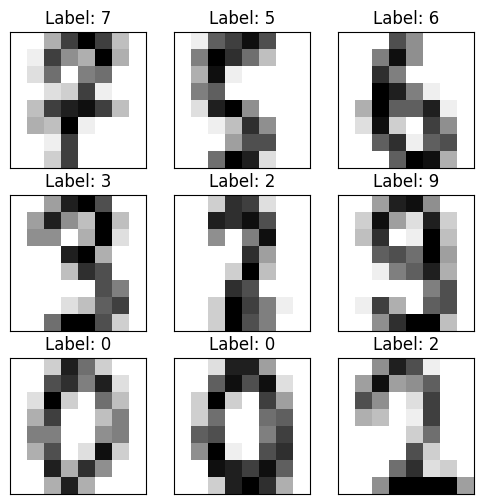

In [ ]:
# Selecting 9 random indices
random_indices = np.random.choice(len(digits.images), 9, replace=False)

# Creating a 3x3 grid plot
fig, axes = plt.subplots(3, 3, figsize=(6, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[random_indices[i]], cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(f"Label: {digits.target[random_indices[i]]}")

    # Removing axis labels
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

As you can see, these images are very low resolution. This is because they were originally scanned from paper forms, and then scaled down to 8x8 pixels. This is a common problem in machine learning - the quality of the data is often a limiting factor in the performance of the model. In this case, the low resolution of the images makes it difficult to distinguish between some digits, even for humans. For example, the following images are all labelled as 9, but they look very different:

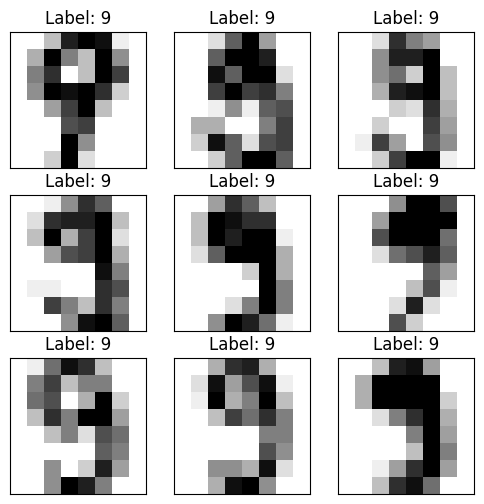

In [ ]:
# Selecting 9 random indices of images labelled as 9
random_indices = np.random.choice(np.where(digits.target == 9)[0], 9, replace=False)

# Creating a 3x3 grid plot
fig, axes = plt.subplots(3, 3, figsize=(6, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[random_indices[i]], cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(f"Label: {digits.target[random_indices[i]]}")

    # Removing axis labels
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

While we are plotting the samples as images, remember that our model is only going to see a 1D array of numbers.

## Train / Test Split

In order to understand how well our model performs on _new_ data, we need to split our dataset into a training set and a test set. The training set will be used to train the model, and the test set will be used to evaluate the performance of the model.

Let's keep some held-out data to be able to measure the generalization performance of our model.

In [ ]:
from sklearn.model_selection import train_test_split

# X_train: The features for the training set.
# X_test: The features for the test set.
# y_train: The labels for the training set.
# y_test: The labels for the test set.
# digits.data: This is the input data (the flattened images).
# digits.target: This is the target data (the labels).
# test_size=0.2: This specifies that 20% of the data should be used for the test set, and the remaining 80% for the training set.
# random_state=42: This ensures that the data split is the same every time the code is run, making the results reproducible.
X_train, X_test, y_train, y_test = train_test_split(
    digits.data,
    digits.target,
    test_size=0.2, # 20% of the data is used for testing
    random_state=42 # Providing a value here means getting the same "random" split every time
)

Let's confirm that the data has been split correctly:

In [ ]:
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (1437, 64)
y_train shape: (1437,)
X_test shape: (360, 64)
y_test shape: (360,)


This is what we expected to see. It's always good to check as you go, to make sure that you haven't made a mistake somewhere - this is something that working in a notebook like this makes it easy to do.

## Preprocessing of the Target Data

The labels that we have are integers between 0 and 9. However, we want to train a neural network to classify the images into one of 10 classes. It can be a little counter-intuitive because we are dealing with numbers, but our classes are not ordinal.

What do we mean by that? Let's imagine we were trying to predict the height of a building (separated into classes) from images. If a given building was actually 10m tall, and our model predicted 9m, we would consider that to be a better prediction than if it predicted 1m. This is because the classes are ordinal - there is meaning in the difference between the classes.

In our case, even though we are dealing with numbers, the classes are not ordinal. If a given image is actually a 9, and our model predicts 8, we would consider that to be just as bad as if it predicted 1. This is because the classes are not ordered, and the difference between the classes is not meaningful.

Because of this, we need to convert our labels from an integer value into a one-hot encoded vector. This means that each label will be represented as a vector of length 10, with a 1 in the position corresponding to the class, and 0s everywhere else. For example, the label 9 would be represented as `[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]`. This is a common way of representing categorical data in machine learning. By doing this, we ensure that our model is taught the correct relationship between the classes.

In [ ]:
# One-hot encoding represents each digit as a distinct category.
# This is more appropriate for training a classification model.
from tensorflow.keras.utils import to_categorical

# Print the value of the first training label before one-hot encoding to show the original format (an integer).
print(f'Before one-hot encoding: {y_train[0]}')

# Convert the training labels (y_train) and testing labels (y_test) into one-hot encoded vectors.
# num_classes=10 specifies that there are 10 possible classes (digits 0-9).
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Print the first training label again after one-hot encoding
# to show the new format (a vector with a 1 in the position corresponding to the class).
print(f'After one-hot encoding: {y_train[0]}')

Before one-hot encoding: 6
After one-hot encoding: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


## Feed Forward Neural Networks with Keras

Now that we have prepared our data, it's time to build a simple neural network! In this section, we will use the Keras API to build a simple feed forward neural network. We will then train the model on the MNIST dataset, and evaluate its performance on the test set.

In most modern deep learning frameworks, the process of building a model can be broken down into a few steps:

- Define the model architecture: this is where we define the layers of the model, and how they are connected to each other.
- Compile the model: this is where we define the loss function, the optimizer, and the metrics that we want to use to evaluate the model.
- Train the model: this is where we train the model on the training data.

Let's start with defining the model architecture. There are two ways to do this in Keras - the Sequential API and the Functional API. The Sequential API is the simplest way to build a model, and is suitable for most use cases. The Functional API is more flexible, and allows you to build more complex models. We will start with the Sequential API, and then we will look at the Functional API later in the course.

Our simple neural network will be "fully-connected". This means that each neuron in a given layer is connected to every neuron in the next layer. This is also known as a "dense" layer. We will use the `Dense` class from Keras to define our layers.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense

# Initializes the model architecture using Sequential API.
model = Sequential()

# Input layer specifying the shape of the input data (64 features).
model.add(Input(shape=(64,)))               # Input tensor specifying the shape

# First hidden layer with 64 neurons and the ReLU activation function.
model.add(Dense(64, activation='relu'))     # 64 neurons, ReLU activation

# Second hidden layer with 64 neurons and the ReLU activation function.
model.add(Dense(64, activation='relu'))     # 64 neurons, ReLU activation

# Output layer with 10 neurons (for the 10 digits) and the softmax activation function,
# which outputs a probability distribution over the classes.
model.add(Dense(10, activation='softmax'))  # 10 neurons, softmax activation

# Print a summary of the model's architecture including the number of parameters in each layer.
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,970 (35.04 KB)

 Trainable params: 8,970 (35.04 KB)

 Non-trainable params: 0 (0.00 B)

Congratulations! You have just built your first neural network with Keras. As we can confirm from the `model.summary()` output, our model has 3 layers. The first layer has 64 neurons, the second layer has 64 neurons, and the output layer has 10 neurons. The output layer uses the softmax activation function, which is commonly used for multi-class classification problems. The other layers use the ReLU activation function, which is commonly used for hidden layers in neural networks.

Next, we need to compile the model. This is where we define the loss function, the optimizer, and the metrics that we want to use to evaluate the model. We will use the `compile` method of the model to do this.

In [ ]:
# Define how to train the model.
# 1. loss='categorical_crossentropy': This specifies the loss function to be used. 'categorical_crossentropy' is suitable for multi-class classification problems where the labels are one-hot encoded.
# 2. optimizer=SGD(learning_rate=0.001): This specifies the optimizer to use for updating the model's weights during training. In this case, it's the SGD optimizer with a default learning rate.
# 3. metrics=['accuracy']: This specifies the metrics to be evaluated during training and testing. 'accuracy' calculates the percentage of correctly classified samples.
model.compile(
    loss='categorical_crossentropy',  # Loss function, (common in classification).
    optimizer='sgd',                  # Optimizer (Stochastic Gradient Descent (SGD) algorithm)
    metrics=['accuracy']              # Metrics to evaluate the model
)

Because we are predicting which class a sample belongs to, we will use the `categorical_crossentropy` function. This loss function is commonly used for multi-class classification problems.

For our optimizer, we are using the standard stochastic gradient descent (SGD) algorithm. This is a simple optimizer that works well for many problems. We will look at more advanced optimizers later in the course.

Finally, we are using the `accuracy` metric to evaluate the model. This is a common metric for classification problems, and it is simply the fraction of samples that are correctly classified. This is an easier metric for us to understand, but it's not quite as useful for actually training the model (for example, it doesn't tell us how "confident" the model is in its predictions).

Now that we have (a) defined the model architecture and (b) compiled the model, we are ready to train the model. We will use the `fit` method of the model to do this.

In [ ]:
# Start the training process.
# X_train: This is the training data (the features).
# y_train: This is the training labels (the one-hot encoded digits).
# epochs=5: This specifies the number of times the model will iterate over the entire training dataset.
# batch_size=32: This determines the number of samples per gradient update during training.
# validation_split=0.2: This reserves 20% of the training data to be used as validation data.
# The model's performance on this data is evaluated at the end of each epoch, providing insight into how well the model generalizes to unseen data during training.

model.fit(
    X_train,                # Training data
    y_train,                # Training labels
    epochs=5,               # Number of epochs
    batch_size=32,          # Number of samples per batch
    validation_split=0.2    # Use 20% of the data for validation
)

# Output statistics:
# Epoch 5/5
# 36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9592 - loss: 0.1703 - val_accuracy: 0.9132 - val_loss: 0.1943
# X_train (100%): 1437
# X_train (80%): 1149
# Batch size: 32
# Steps: 1149/32 = 36
# Duration: 4ms/step
# Perfomance:
#   Accuracy (Training data): Increasing (0.3800 -> 0.9592)
#   Loss (Training data):  Deacreasing (2.6847 -> 0.1703)
#   Accuracy (Validation data): Increasing (0.8368 -> 0.9132)
#   Loss (Validation data):  Deacreasing (0.5446 -> 0.1943)

Epoch 1/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3800 - loss: 2.6847 - val_accuracy: 0.8368 - val_loss: 0.5446
Epoch 2/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8446 - loss: 0.4882 - val_accuracy: 0.9097 - val_loss: 0.3300
Epoch 3/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9202 - loss: 0.2895 - val_accuracy: 0.9132 - val_loss: 0.2613
Epoch 4/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9541 - loss: 0.1874 - val_accuracy: 0.9444 - val_loss: 0.2125
Epoch 5/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9592 - loss: 0.1703 - val_accuracy: 0.9132 - val_loss: 0.1943


In [ ]:
import numpy as np
(X_train.shape[0] * 0.8) / 32

NUM_TRAINING_SAMPLES = int(X_train.shape[0] * 0.8)
NUM_TRAINING_SAMPLES

print(f"Number of training samples: {NUM_TRAINING_SAMPLES}")
print(f"Number of validation samples: {X_train.shape[0] - NUM_TRAINING_SAMPLES}")
# Batch sizes
print(f"Batch size: {32}")
# Number of steps
print(f"Number of steps: {NUM_TRAINING_SAMPLES // 32}")


Number of training samples: 1149
Number of validation samples: 288
Batch size: 32
Number of steps: 35


We have now trained our model! We can see that the model has been trained for 5 epochs, and the loss and accuracy have been printed for each epoch. We can also see that the model has been evaluated on the validation data at the end of each epoch. This is useful for us to see how the model is performing on data that it hasn't seen during training.

Once the model is trained, it's time to evaluate the model on the test set. We can use the `evaluate` method of the model to do this. If you were building a model for a real-world application, this is the very last thing you would do, and the result here would be the figure you'd report in your paper or presentation.

In [ ]:
# Display the final loss value after the model has been evaluated on the test set.

loss, accuracy = model.evaluate(X_test, y_test)

print(f'Loss:     {loss:.2f}')
print(f'Accuracy: {accuracy*100:.2f}%')

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9436 - loss: 0.1789  
Loss:     0.22
Accuracy: 93.33%


Hopefully you have achieved an accuracy of around 95%. This is pretty good, but we can do better! In the next section, we will look at how we can improve the performance of our model by using a more advanced optimizer. But before we get there, let's do one other thing - let's look at the predictions that our model is making on the test set. When you are building a model, it's often useful to have a look at some of the examples your model is getting wrong. Sometimes this can reveal problems with the data, or it can give you ideas for how to improve your model.

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


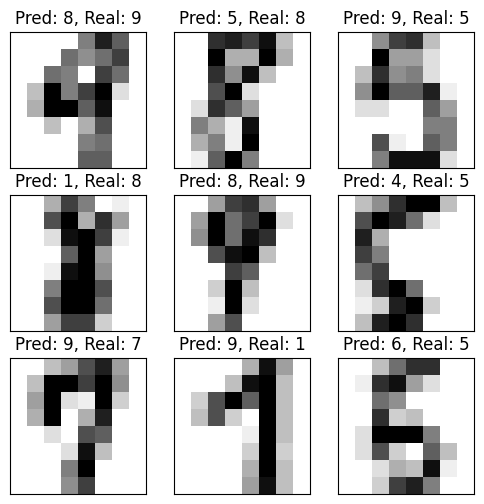

In [ ]:
# Get the predictions for the test data
predictions = model.predict(X_test)

# Get the index of the largest probability (i.e. the predicted class)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)
misclassified_indices = np.where(predicted_classes != true_classes)[0]

# Get the misclassified samples themselves
misclassified_samples = X_test[misclassified_indices]
misclassified_labels = np.argmax(y_test[misclassified_indices], axis=1)

# Pick 9 random misclassified samples
random_indices = np.random.choice(len(misclassified_indices), 9, replace=False)

fig, axes = plt.subplots(3, 3, figsize=(6, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(misclassified_samples[random_indices[i]].reshape(8, 8), cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(f"Pred: {predicted_classes[misclassified_indices[random_indices[i]]]}, Real: {misclassified_labels[random_indices[i]]}")

    # Removing axis labels
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

What do you think? Would you have made the same mistakes as the model? Determining whether the mistakes are "understandable" is a rough way of seeing if you could improve the model further, or if this is the best you can do with the data you have.

### b) Exercises: Impact of the Optimizer

In this section, you will play around with the optimizer and see how it affects the performance of the model. We will start with the standard SGD optimizer, and then we will look at more advanced optimizers.

1. Try decreasing the learning rate of the SGD optimizer by a factor of 10, or 100. What do you observe?
2. Try increasing the learning rate of the SGD optimizer. What happens?
3. The SGD optimizer has a momentum parameter. In a nutshell, this parameter controls how much the gradient from the previous step affects the current step. Try enabling momentum in the SGD optimizer with a value of 0.9. What happens?
  
**Notes**:

The keras API documentation is available at:

https://www.tensorflow.org/api_docs/python/tf/keras

It is also possible to learn more about the parameters of a class by using the question mark: type and evaluate:

```python
optimizers.SGD?
```

in a jupyter notebook cell.

It is also possible to type the beginning of a function call / constructor and type "shift-tab" after the opening paren:

```python
optimizers.SGD(<shift-tab>
```

In [ ]:
# 1. Decreasing the learning rate

# Decreasing the learning rate generally makes the training process slower but can help the model converge
# to a better solution by taking smaller steps in the direction of the minimum of the loss function.
# It can prevent overshooting the minimum which can happen with a large learning rate.
# The default learning rate for the SGD optimizer in Keras is 0.01.

from tensorflow.keras.optimizers import SGD

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense

model = Sequential()

# Input layer
model.add(Input(shape=(64,)))               # Input tensor specifying the shape
model.add(Dense(64, activation='relu'))     # 64 neurons, ReLU activation

# Hidden layer
model.add(Dense(64, activation='relu'))     # 64 neurons, ReLU activation

# Output layer
model.add(Dense(10, activation='softmax'))  # 10 neurons, softmax activation

model.summary()

model.compile(
    loss='categorical_crossentropy',        # Loss function
    optimizer=SGD(learning_rate=0.001),     # Optimizer, adjusting learning rate
    metrics=['accuracy']                    # Metrics to evaluate the model
)

model.fit(
    X_train,                                # Training data
    y_train,                                # Training labels
    epochs=5,                               # Number of epochs
    batch_size=32,                          # Number of samples per batch
    validation_split=0.2                    # Use 20% of the data for validation
)

loss, accuracy = model.evaluate(X_test, y_test)

print(f'Loss:     {loss:.2f}')
print(f'Accuracy: {accuracy*100:.2f}%')


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,970 (35.04 KB)

 Trainable params: 8,970 (35.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1141 - loss: 5.3885 - val_accuracy: 0.1806 - val_loss: 2.5976
Epoch 2/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2652 - loss: 2.3079 - val_accuracy: 0.3889 - val_loss: 1.8221
Epoch 3/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4760 - loss: 1.6484 - val_accuracy: 0.5347 - val_loss: 1.4651
Epoch 4/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5915 - loss: 1.3205 - val_accuracy: 0.6146 - val_loss: 1.2461
Epoch 5/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6525 - loss: 1.1224 - val_accuracy: 0.6562 - val_loss: 1.0924
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6458 - loss: 1.0882  
Loss:     1.06
Accuracy: 66.39%


In [ ]:
# 2. Increasing the learning rate
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense

model = Sequential()

# Input layer
model.add(Input(shape=(64,)))               # Input tensor specifying the shape
model.add(Dense(64, activation='relu'))     # 64 neurons, ReLU activation

# Hidden layer
model.add(Dense(64, activation='relu'))     # 64 neurons, ReLU activation

# Output layer
model.add(Dense(10, activation='softmax'))  # 10 neurons, softmax activation

model.summary()

model.compile(
    loss='categorical_crossentropy',        # Loss function
    optimizer=SGD(learning_rate=0.1),       # Optimizer with increased learning rate
    metrics=['accuracy']                    # Metrics to evaluate the model
)

model.fit(
    X_train,                                # Training data
    y_train,                                # Training labels
    epochs=5,                               # Number of epochs
    batch_size=32,                          # Number of samples per batch
    validation_split=0.2                    # Use 20% of the data for validation
)

loss, accuracy = model.evaluate(X_test, y_test)

print(f'Loss:     {loss:.2f}')
print(f'Accuracy: {accuracy*100:.2f}%')


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,970 (35.04 KB)

 Trainable params: 8,970 (35.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1816 - loss: 7.1565 - val_accuracy: 0.1736 - val_loss: 2.1192
Epoch 2/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3259 - loss: 1.9249 - val_accuracy: 0.3715 - val_loss: 1.6884
Epoch 3/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3550 - loss: 1.7519 - val_accuracy: 0.3090 - val_loss: 1.7817
Epoch 4/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3411 - loss: 1.8092 - val_accuracy: 0.3993 - val_loss: 1.6230
Epoch 5/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3600 - loss: 1.6253 - val_accuracy: 0.3924 - val_loss: 1.5063
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4582 - loss: 1.3675  
Loss:     1.42
Accuracy: 42.50%


In [ ]:
# 3. SGD with momentum

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense

model = Sequential()

# Input layer
model.add(Input(shape=(64,)))               # Input tensor specifying the shape
model.add(Dense(64, activation='relu'))     # 64 neurons, ReLU activation

# Hidden layer
model.add(Dense(64, activation='relu'))     # 64 neurons, ReLU activation

# Output layer
model.add(Dense(10, activation='softmax'))  # 10 neurons, softmax activation

model.summary()

model.compile(
    loss='categorical_crossentropy',                # Loss function
    optimizer=SGD(learning_rate=0.01,momentum=0.9), # Optimizer
    metrics=['accuracy']                            # Metrics to evaluate the model
)

model.fit(
    X_train,                                # Training data
    y_train,                                # Training labels
    epochs=5,                               # Number of epochs
    batch_size=32,                          # Number of samples per batch
    validation_split=0.2                    # Use 20% of the data for validation
)

loss, accuracy = model.evaluate(X_test, y_test)

print(f'Loss:     {loss:.2f}')
print(f'Accuracy: {accuracy*100:.2f}%')


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,970 (35.04 KB)

 Trainable params: 8,970 (35.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4099 - loss: 2.5150 - val_accuracy: 0.8715 - val_loss: 0.4457
Epoch 2/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8867 - loss: 0.3919 - val_accuracy: 0.8854 - val_loss: 0.3182
Epoch 3/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9515 - loss: 0.1535 - val_accuracy: 0.9306 - val_loss: 0.2113
Epoch 4/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9454 - loss: 0.1714 - val_accuracy: 0.9479 - val_loss: 0.1712
Epoch 5/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9713 - loss: 0.0978 - val_accuracy: 0.9618 - val_loss: 0.1229
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9582 - loss: 0.1378  
Loss:     0.16
Accuracy: 95.00%


Next, let's try a more advanced optimizer. Adam is likely the most popular optimizer for deep learning. It is an adaptive learning rate optimizer, which means that it automatically adjusts the learning rate based on how the training is going. This can be very useful, as it means that we don't need to manually tune the learning rate. Let's see how it performs on our model.


1. Replace the SGD optimizer by the Adam optimizer from keras and run it
  with the default parameters.

2. Add another hidden layer with ReLU activation and 64 neurons. Does it improve the model performance?


In [ ]:
# Adam optimizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense

model = Sequential()

# Input layer
model.add(Input(shape=(64,)))                 # Input tensor specifying the shape
model.add(Dense(64, activation='relu'))       # 64 neurons, ReLU activation

# Hidden layer
model.add(Dense(64, activation='relu'))       # 64 neurons, ReLU activation

# Output layer
model.add(Dense(10, activation='softmax'))    # 10 neurons, softmax activation

model.summary()

model.compile(
    loss='categorical_crossentropy',          # Loss function
    optimizer=Adam(),                         # Optimizer
    metrics=['accuracy']                      # Metrics to evaluate the model
)

model.fit(
    X_train,                                  # Training data
    y_train,                                  # Training labels
    epochs=5,                                 # Number of epochs
    batch_size=32,                            # Number of samples per batch
    validation_split=0.2                      # Use 20% of the data for validation
)


loss, accuracy = model.evaluate(X_test, y_test)

print(f'Loss:     {loss:.2f}')
print(f'Accuracy: {accuracy*100:.2f}%')


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,970 (35.04 KB)

 Trainable params: 8,970 (35.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2463 - loss: 4.3450 - val_accuracy: 0.7014 - val_loss: 1.0285
Epoch 2/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7714 - loss: 0.7356 - val_accuracy: 0.8438 - val_loss: 0.5205
Epoch 3/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8850 - loss: 0.3456 - val_accuracy: 0.8819 - val_loss: 0.3567
Epoch 4/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9406 - loss: 0.2071 - val_accuracy: 0.8958 - val_loss: 0.2928
Epoch 5/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9506 - loss: 0.1570 - val_accuracy: 0.9236 - val_loss: 0.2506
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9670 - loss: 0.1395  
Loss:     0.17
Accuracy: 95.00%


In [ ]:
# Extra hidden layer

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense

model = Sequential()

# Input layer
model.add(Input(shape=(64,)))               # Input tensor specifying the shape
model.add(Dense(64, activation='relu'))     # 64 neurons, ReLU activation

# Hidden layer
model.add(Dense(64, activation='relu'))     # 64 neurons, ReLU activation

# Hidden layer
model.add(Dense(64, activation='relu'))     # 64 neurons, ReLU activation

# Hidden layer
model.add(Dense(64, activation='relu'))     # 64 neurons, ReLU activation


# Output layer
model.add(Dense(10, activation='softmax'))  # 10 neurons, softmax activation

model.compile(
    loss='categorical_crossentropy',        # Loss function
    optimizer=Adam(),                       # Optimizer
    metrics=['accuracy']                    # Metrics to evaluate the model
)

model.fit(
    X_train,                                # Training data
    y_train,                                # Training labels
    epochs=5,                               # Number of epochs
    batch_size=32,                          # Number of samples per batch
    validation_split=0.2                    # Use 20% of the data for validation
)


loss, accuracy = model.evaluate(X_test, y_test)

print(f'Loss:     {loss:.2f}')
print(f'Accuracy: {accuracy*100:.2f}%')


Epoch 1/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3472 - loss: 1.9147 - val_accuracy: 0.7986 - val_loss: 0.6746
Epoch 2/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8588 - loss: 0.5299 - val_accuracy: 0.8819 - val_loss: 0.3432
Epoch 3/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9366 - loss: 0.2214 - val_accuracy: 0.9444 - val_loss: 0.2066
Epoch 4/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9631 - loss: 0.1548 - val_accuracy: 0.9236 - val_loss: 0.2139
Epoch 5/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9772 - loss: 0.0851 - val_accuracy: 0.9236 - val_loss: 0.1762
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9615 - loss: 0.1058  
Loss:     0.12
Accuracy: 95.56%


Results:


* Original SGD (default learning rate 0.01): Achieved an accuracy of approximately 93.33%.
* SGD with decreased learning rate (0.001): The accuracy dropped significantly to around 66.39%. This shows that a learning rate that is too small can lead to very slow convergence or getting stuck in a poor local minimum within the limited number of epochs.
* SGD with increased learning rate (0.1): The accuracy was also lower, around 42.50%. A learning rate that is too large can cause the optimization process to overshoot the minimum of the loss function and even diverge.
* SGD with momentum (learning rate 0.01, momentum 0.9): The accuracy improved to 95.00%. Adding momentum helps accelerate SGD in the relevant direction and dampens oscillations, leading to faster and sometimes better convergence.
* Adam optimizer (default settings): The accuracy reached 95.00%. Adam is an adaptive optimizer that adjusts the learning rate for each parameter, often leading to good performance without manual tuning of the learning rate.
* Adam optimizer with an extra hidden layer: The accuracy slightly improved to 95.56%. Adding more layers can increase the model's capacity to learn more complex patterns, potentially leading to better performance if the added complexity is warranted by the data and doesn't lead to overfitting.

Conculusion: Using a learning rate that is too high or too low for basic SGD can significantly hurt performance. Adding momentum to SGD or using an adaptive optimizer like Adam can improve the training process and lead to better accuracy. Adding more layers can also improve performance, as seen with the Adam optimizer, but it's not guaranteed and depends on the dataset and model complexity.

### Exercises: Forward Pass and Generalization

Let's look in more detail at how the model makes predictions on the test set. We will walk through each step of making predictions, examining exactly what's going on.

To start, we will apply our model to the test set, and look at what we get as output:

In [ ]:
predictions_tf = model(X_test)
predictions_tf[:5]    # Display the probability distributions for the first 5 test samples.

<tf.Tensor: shape=(5, 10), dtype=float32, numpy=
array([[8.0278487e-06, 1.0622015e-03, 4.1083354e-07, 5.9641775e-07,
        3.0239975e-05, 1.1463054e-05, 9.9820346e-01, 4.4515746e-06,
        6.7882711e-04, 4.5622124e-07],
       [7.7001381e-08, 2.1738965e-06, 1.3291766e-06, 3.7999744e-05,
        5.6652450e-05, 6.9958814e-03, 6.9050019e-09, 9.8468940e-05,
        1.5251343e-04, 9.9265486e-01],
       [1.0688281e-08, 5.9796655e-08, 5.2060037e-05, 9.9979258e-01,
        5.1863818e-08, 6.2625943e-05, 6.6115016e-09, 2.7265583e-05,
        6.4366854e-05, 9.2783768e-07],
       [1.8349165e-04, 1.7432687e-04, 1.1520336e-03, 1.3341355e-02,
        3.4455566e-03, 2.2905190e-02, 1.9495290e-06, 9.1622508e-01,
        4.4563054e-03, 3.8114674e-02],
       [5.6343729e-06, 5.9140682e-05, 9.3561441e-01, 5.9514560e-02,
        7.1929560e-07, 9.2228416e-05, 6.9289026e-06, 5.6769315e-04,
        4.0023229e-03, 1.3622445e-04]], dtype=float32)>

In [ ]:
# <tf.Tensor: shape=(5, 10), dtype=float32, numpy=
# array([[8.0278487e-06, 1.0622015e-03, 4.1083354e-07, 5.9641775e-07,
#         3.0239975e-05, 1.1463054e-05, 9.9820346e-01, 4.4515746e-06,
#         6.7882711e-04, 4.5622124e-07],
#        [7.7001381e-08, 2.1738965e-06, 1.3291766e-06, 3.7999744e-05,
#         5.6652450e-05, 6.9958814e-03, 6.9050019e-09, 9.8468940e-05,
#         1.5251343e-04, 9.9265486e-01],
#        [1.0688281e-08, 5.9796655e-08, 5.2060037e-05, 9.9979258e-01,
#         5.1863818e-08, 6.2625943e-05, 6.6115016e-09, 2.7265583e-05,
#         6.4366854e-05, 9.2783768e-07],
#        [1.8349165e-04, 1.7432687e-04, 1.1520336e-03, 1.3341355e-02,
#         3.4455566e-03, 2.2905190e-02, 1.9495290e-06, 9.1622508e-01,
#         4.4563054e-03, 3.8114674e-02],
#        [5.6343729e-06, 5.9140682e-05, 9.3561441e-01, 5.9514560e-02,
#         7.1929560e-07, 9.2228416e-05, 6.9289026e-06, 5.6769315e-04,
#         4.0023229e-03, 1.3622445e-04]], dtype=float32)>
# Each row in the tensor corresponds to one image. There are 10 columns, and each column represents one of the possible digit classes (0 through 9). The value in each cell is the probability that the model assigned to that particular image belonging to that specific digit class.
# For example, in the first row: [8.0278487e-06, 1.0622015e-03, ..., 9.9820346e-01, ..., 4.5622124e-07]
# The highest probability is 9.9820346e-01 (which is very close to 1), located at the 6th index (remembering that indices start from 0). This means the model is highly confident that the first image is a '6'.
# The values are in scientific notation (e.g., 8.0278487e-06 is 8.0278487 * 10^-6, a very small number).

In [ ]:
# Check the type and shape of the predictions_tf variable.
# The output TensorShape([360, 10]) indicates that the tensor has 360 rows and 10 columns.
# This aligns with the 360 samples in our test set and the 10 possible digit classes.
type(predictions_tf), predictions_tf.shape

(tensorflow.python.framework.ops.EagerTensor, TensorShape([360, 10]))

The raw output of the model is a tensor of shape `(360, 10)`. This means that we have 360 samples, and for each sample we have 10 values. Each of these values represents the probability that the sample belongs to a given class. This means that we have 10 probabilities for each sample, and the sum of these probabilities is 1. We can confirm this by summing the probabilities for each sample:

In [ ]:
import tensorflow as tf
# Calculate the sum of probabilities across each row (for each sample) in the predictions_tf tensor and displays the sum for the first 5 samples.
# Slice the result to show only the first 5 values (the sums for the first 5 samples).
# Because the output layer uses softmax activation the sum of probabilities for each sample should ideally be 1.
tf.reduce_sum(predictions_tf, axis=1)[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([1.0000001 , 1.        , 0.99999994, 1.        , 0.9999998 ],
      dtype=float32)>

...okay, there might be a small rounding error here and there. This is to do with how floating point numbers are represented in computers, and it's not something we need to worry about for now.

We can also extract the label with the highest probability using the tensorflow API:

In [ ]:
# Extracts the predicted class label for each test sample based on the highest probability output by the model.
# Return the index with the largest value across a specified axis.
predicted_labels_tf = tf.argmax(predictions_tf, axis=1)

# Display the first 5 predicted labels, which are the digits the model predicts for the first 5 test samples.
predicted_labels_tf[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([6, 9, 3, 7, 2])>

One helpful aspect of this approach is that we don't just get the prediction, but also a sense of how confident the model is in its prediction. To see this in practice, let's take a look at some of the predictions the model is highly confident about (i.e. a lot of the probability mass is on one class):

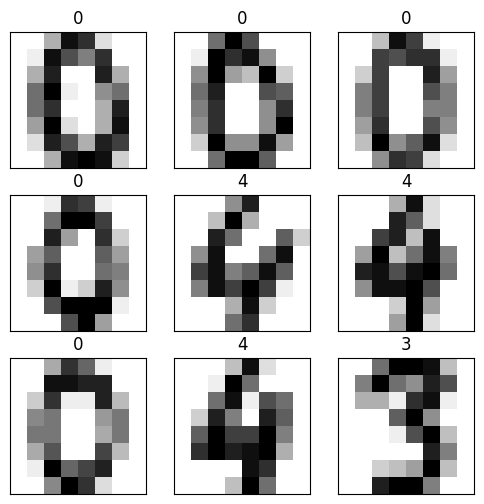

In [ ]:
# Get the values corresponding to the predicted labels for each sample
predicted_values_tf = tf.reduce_max(predictions_tf, axis=1)

# Get the indices of the samples with the highest predicted values
most_confident_indices_tf = tf.argsort(predicted_values_tf, direction='DESCENDING').numpy()[:9]

# Get the 9 most confident samples
most_confident_samples_tf = X_test[most_confident_indices_tf]

# Get the true labels for the 9 most confident samples
most_confident_labels_tf = np.argmax(y_test[most_confident_indices_tf], axis=1)

# Plot the 9 most confident samples
fig, axes = plt.subplots(3, 3, figsize=(6, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(most_confident_samples_tf[i].reshape(8, 8), cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(f"{most_confident_labels_tf[i]}")

    # Removing axis labels
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

## Impact of Initialization

Let's study the impact of a bad initialization when training
a deep feed forward network.

By default, Keras dense layers use the "Glorot Uniform" initialization
strategy to initialize the weight matrices:

- each weight coefficient is randomly sampled from [-scale, scale]
- scale is proportional to $\frac{1}{\sqrt{n_{in} + n_{out}}}$

This strategy is known to work well to initialize deep neural networks
with "tanh" or "relu" activation functions and then trained with
standard SGD.

To assess the impact of initialization let us plug an alternative init
scheme into a 2 hidden layers networks with "tanh" activations.
For the sake of the example let's use normal distributed weights
with a manually adjustable scale (standard deviation) and see the
impact the scale value:

In [ ]:
from tensorflow.keras import initializers
from tensorflow.keras import optimizers

input_dim = 64
hidden_dim = 64
output_dim = 10

normal_init = initializers.TruncatedNormal(stddev=0.01, seed=42)

model = Sequential()
model.add(Dense(hidden_dim, input_dim=input_dim, activation="tanh",
                kernel_initializer=normal_init))
model.add(Dense(hidden_dim, activation="tanh",
                kernel_initializer=normal_init))
model.add(Dense(output_dim, activation="softmax",
                kernel_initializer=normal_init))

model.compile(optimizer=optimizers.SGD(learning_rate=0.1),
              loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.layers

[<Dense name=dense_20, built=True>,
 <Dense name=dense_21, built=True>,
 <Dense name=dense_22, built=True>]

Let's have a look at the parameters of the first layer after initialization but before any training has happened:

In [ ]:
model.layers[0].weights

[<Variable path=sequential_6/dense_20/kernel, shape=(64, 64), dtype=float32, value=[[ 0.00015817 -0.01590087  0.00103594 ...  0.00962818  0.00624957
    0.00994726]
  [ 0.0081879   0.00756818 -0.00668142 ...  0.01084459 -0.00317478
   -0.00549116]
  [-0.00086618 -0.00287623  0.00391693 ...  0.00064558 -0.00420471
    0.00174566]
  ...
  [-0.0029006  -0.0091218   0.00804327 ... -0.01407086  0.00952832
   -0.01348555]
  [ 0.00375078  0.00967842  0.00098119 ... -0.00413454  0.01695471
    0.00025196]
  [ 0.00459809  0.01223094 -0.00213172 ...  0.01246831 -0.00714749
   -0.00868595]]>,
 <Variable path=sequential_6/dense_20/bias, shape=(64,), dtype=float32, value=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]>]

In [ ]:
w = model.layers[0].weights[0].numpy()
w

array([[ 0.00015817, -0.01590087,  0.00103594, ...,  0.00962818,
         0.00624957,  0.00994726],
       [ 0.0081879 ,  0.00756818, -0.00668142, ...,  0.01084459,
        -0.00317478, -0.00549116],
       [-0.00086618, -0.00287623,  0.00391693, ...,  0.00064558,
        -0.00420471,  0.00174566],
       ...,
       [-0.0029006 , -0.0091218 ,  0.00804327, ..., -0.01407086,
         0.00952832, -0.01348555],
       [ 0.00375078,  0.00967842,  0.00098119, ..., -0.00413454,
         0.01695471,  0.00025196],
       [ 0.00459809,  0.01223094, -0.00213172, ...,  0.01246831,
        -0.00714749, -0.00868595]], dtype=float32)

In [ ]:
# Expected standard deviation of the initial weights to be approximately 0.0088,
# which is close to the stddev=0.01 we specified for the TruncatedNormal initializer.
# This confirms that the weights were initialized as expected.

w.std()

np.float32(0.008835949)

In [ ]:
b = model.layers[0].weights[1].numpy()
b                                       # Expected the initial biases are all zeros.

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

Epoch 1/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1679 - loss: 2.2981
Epoch 2/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4670 - loss: 1.9696
Epoch 3/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6623 - loss: 1.1415
Epoch 4/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8124 - loss: 0.6665
Epoch 5/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9221 - loss: 0.3372
Epoch 6/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9388 - loss: 0.2396
Epoch 7/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9643 - loss: 0.1618
Epoch 8/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9687 - loss: 0.1405
Epoch 9/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9702 - loss: 0.1169
Epoch 10/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9737 - loss: 0.0964
Epoch 11/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9877 - loss: 0.0747
Epoch 12/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9860 - lo

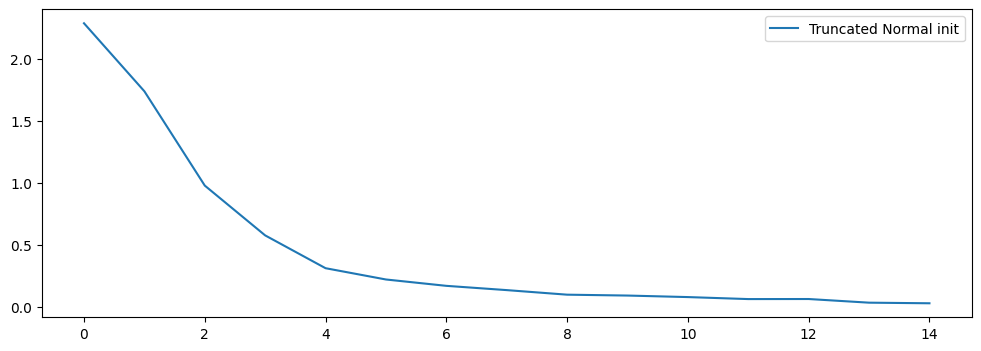

In [ ]:
# Train the model for 15 epochs using the fit method and plots the training loss over epochs.
# The output shows the training progress for each epoch, including the accuracy and loss on the training data.
history = model.fit(X_train, y_train, epochs=15, batch_size=32)

plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label="Truncated Normal init")
plt.legend();

In [ ]:
# The plot visually represents how the training loss decreases over the epochs.
# A decreasing loss indicates that the model is learning and improving its performance on the training data with this specific initialization.

Once the model has been fit, the weights have been updated and notably the biases are no longer 0:

In [ ]:
# Display the kernel weights and biases of the first layer of the model after it has been trained for 15 epochs in the previous cell.
# Notice that the values in the weight matrix (kernel) and the bias vector (bias) are no longer the small, structured values from the initialization.
# They have been updated during the training process by the optimizer (SGD in this case) based on the training data and the loss function.
# Comparing this output to the output of cell above clearly shows the impact of training on the model's parameters.
model.layers[0].weights

[<Variable path=sequential_6/dense_20/kernel, shape=(64, 64), dtype=float32, value=[[ 1.58170762e-04 -1.59008689e-02  1.03594456e-03 ...  9.62818228e-03
    6.24957308e-03  9.94726177e-03]
  [ 1.49030825e-02 -8.67892150e-03 -1.03885047e-02 ... -1.40291010e-03
   -1.40120136e-02 -1.95912477e-02]
  [ 5.74610233e-02 -4.17459495e-02 -6.29832372e-02 ... -3.67650501e-02
   -1.21269345e-01  7.39126876e-02]
  ...
  [ 1.31059671e-02  4.07435326e-03  1.37957200e-01 ... -1.09831817e-01
    6.44096583e-02 -1.72591358e-01]
  [ 2.03717481e-02 -5.13245389e-02  8.86910334e-02 ... -7.56032988e-02
   -5.86187653e-03 -8.85823816e-02]
  [ 2.88800895e-02  6.57383585e-03  4.27959822e-02 ...  6.71238899e-02
    1.85409095e-02 -3.93970795e-02]]>,
 <Variable path=sequential_6/dense_20/bias, shape=(64,), dtype=float32, value=[ 2.0678232e-05 -1.6043864e-03  1.3826711e-03 -1.4582040e-03
  -5.7342472e-03 -3.2474866e-04 -7.7656377e-04  2.9326754e-04
   4.1169970e-04 -5.6264037e-04  4.4910441e-04  4.4506099e-03
  -2

#### Questions:

- Try the following initialization schemes and see whether
  the SGD algorithm can successfully train the network or
  not:
  
  - a very small e.g. `stddev=1e-3`
  - a larger scale e.g. `stddev=1` or `10`
  - initialize all weights to 0 (constant initialization)
  
- What do you observe? Can you find an explanation for those
  outcomes?

- Are more advanced solvers such as SGD with momentum or Adam able
  to deal better with such bad initializations?

### Experiment with small stddev=1e-3,

In [ ]:
from tensorflow.keras import initializers
from tensorflow.keras import optimizers

input_dim = 64
hidden_dim = 64
output_dim = 10

# Modifying the model definition cell to use stddev=1e-3.
normal_init = initializers.TruncatedNormal(stddev=1e-3, seed=42)

model = Sequential()
model.add(Dense(hidden_dim, input_dim=input_dim, activation="tanh",
                kernel_initializer=normal_init))
model.add(Dense(hidden_dim, activation="tanh",
                kernel_initializer=normal_init))
model.add(Dense(output_dim, activation="softmax",
                kernel_initializer=normal_init))

model.compile(optimizer=optimizers.SGD(learning_rate=0.1),
              loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0786 - loss: 2.3034
Epoch 2/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1216 - loss: 2.3018
Epoch 3/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1008 - loss: 2.3026
Epoch 4/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1122 - loss: 2.3017
Epoch 5/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1027 - loss: 2.3022
Epoch 6/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1043 - loss: 2.3028
Epoch 7/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1074 - loss: 2.3025
Epoch 8/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1092 - loss: 2.3031
Epoch 9/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1059 - loss: 2.3019
Epoch 10/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1637 - loss: 2.2440
Epoch 11/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1925 - loss: 1.8127
Epoch 12/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2549 - lo

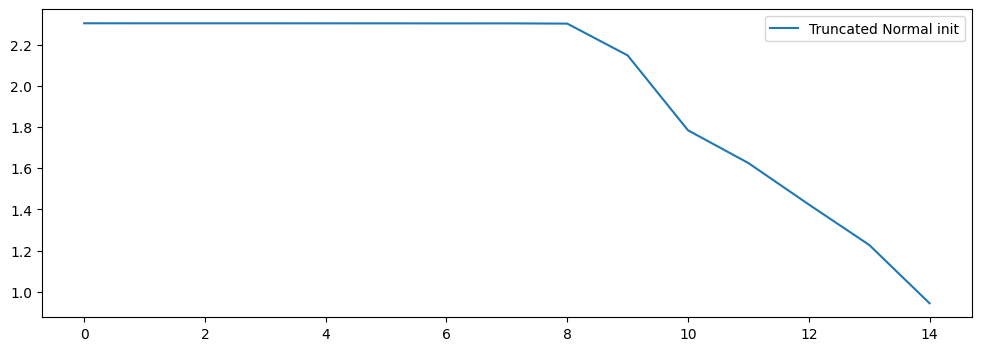

In [ ]:
# Training
history = model.fit(X_train, y_train, epochs=15, batch_size=32)

plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label="Truncated Normal init")
plt.legend();

### Experiment with large stddev = 1.0

In [ ]:
from tensorflow.keras import initializers
from tensorflow.keras import optimizers

input_dim = 64
hidden_dim = 64
output_dim = 10

# Modifying the model definition cell to use stddev=1.0.
normal_init = initializers.TruncatedNormal(stddev=1.0, seed=42)

model = Sequential()
model.add(Dense(hidden_dim, input_dim=input_dim, activation="tanh",
                kernel_initializer=normal_init))
model.add(Dense(hidden_dim, activation="tanh",
                kernel_initializer=normal_init))
model.add(Dense(output_dim, activation="softmax",
                kernel_initializer=normal_init))

model.compile(optimizer=optimizers.SGD(learning_rate=0.1),
              loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2124 - loss: 6.1154
Epoch 2/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3781 - loss: 2.4498
Epoch 3/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4921 - loss: 1.7604
Epoch 4/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5862 - loss: 1.3538
Epoch 5/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6503 - loss: 1.1297
Epoch 6/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6952 - loss: 1.0050
Epoch 7/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7130 - loss: 0.8754
Epoch 8/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7473 - loss: 0.8646
Epoch 9/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7591 - loss: 0.7628
Epoch 10/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7697 - loss: 0.7086
Epoch 11/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7828 - loss: 0.7330
Epoch 12/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7951 - lo

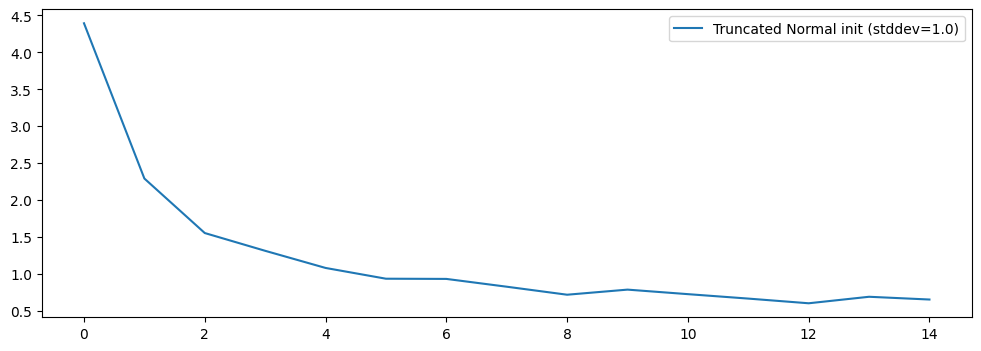

In [ ]:
# Training
history = model.fit(X_train, y_train, epochs=15, batch_size=32)

plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label="Truncated Normal init (stddev=1.0)")
plt.legend();

### Experiment with large stddev = 10.0

Modify the model definition cell to use TruncatedNormal with stddev=10.0.



In [ ]:
from tensorflow.keras import initializers
from tensorflow.keras import optimizers

input_dim = 64
hidden_dim = 64
output_dim = 10

# Modifying the model definition cell to use stddev=10.0.
normal_init = initializers.TruncatedNormal(stddev=10.0, seed=42)

model = Sequential()
model.add(Dense(hidden_dim, input_dim=input_dim, activation="tanh",
                kernel_initializer=normal_init))
model.add(Dense(hidden_dim, activation="tanh",
                kernel_initializer=normal_init))
model.add(Dense(output_dim, activation="softmax",
                kernel_initializer=normal_init))

model.compile(optimizer=optimizers.SGD(learning_rate=0.1),
              loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1066 - loss: 96.4912 
Epoch 2/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1339 - loss: 74.4956
Epoch 3/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1500 - loss: 61.8526
Epoch 4/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1728 - loss: 45.5751
Epoch 5/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1859 - loss: 32.4955
Epoch 6/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1577 - loss: 32.7674
Epoch 7/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1403 - loss: 33.5217
Epoch 8/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1502 - loss: 24.4232
Epoch 9/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1800 - loss: 16.0873
Epoch 10/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1747 - loss: 15.9453
Epoch 11/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1615 - loss: 15.0059
Epoch 12/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy:

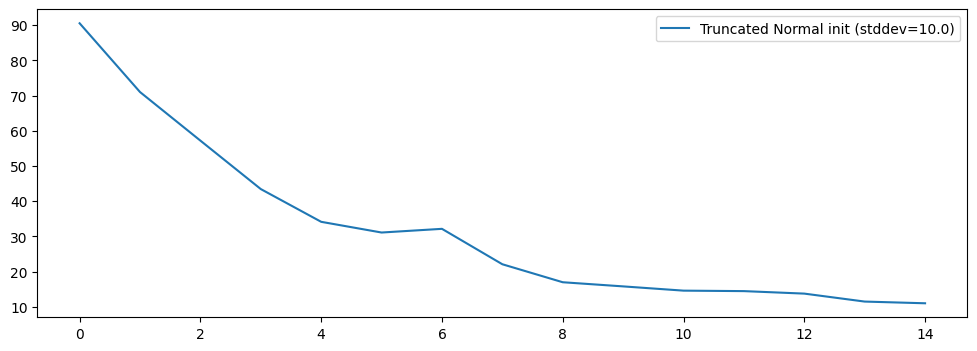

In [ ]:
# Training
history = model.fit(X_train, y_train, epochs=15, batch_size=32)

plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label="Truncated Normal init (stddev=10.0)")
plt.legend();

### Initializing all weights to 0 (constant initialization)

In [ ]:
from tensorflow.keras import initializers
from tensorflow.keras import optimizers

input_dim = 64
hidden_dim = 64
output_dim = 10

# Modifying the model definition cell to use value of 0 for all weights.
zero_init = initializers.Constant(0.)

model = Sequential()
model.add(Dense(hidden_dim, input_dim=input_dim, activation="tanh",
                kernel_initializer=zero_init))
model.add(Dense(hidden_dim, activation="tanh",
                kernel_initializer=zero_init))
model.add(Dense(output_dim, activation="softmax",
                kernel_initializer=zero_init))

model.compile(optimizer=optimizers.SGD(learning_rate=0.1),
              loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0889 - loss: 2.3030
Epoch 2/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1164 - loss: 2.3027
Epoch 3/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1053 - loss: 2.3025
Epoch 4/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1126 - loss: 2.3029
Epoch 5/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1147 - loss: 2.3022
Epoch 6/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1194 - loss: 2.3009
Epoch 7/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1002 - loss: 2.3018
Epoch 8/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1050 - loss: 2.3032
Epoch 9/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0968 - loss: 2.3016
Epoch 10/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0828 - loss: 2.3020
Epoch 11/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1034 - loss: 2.3025
Epoch 12/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1018 - lo

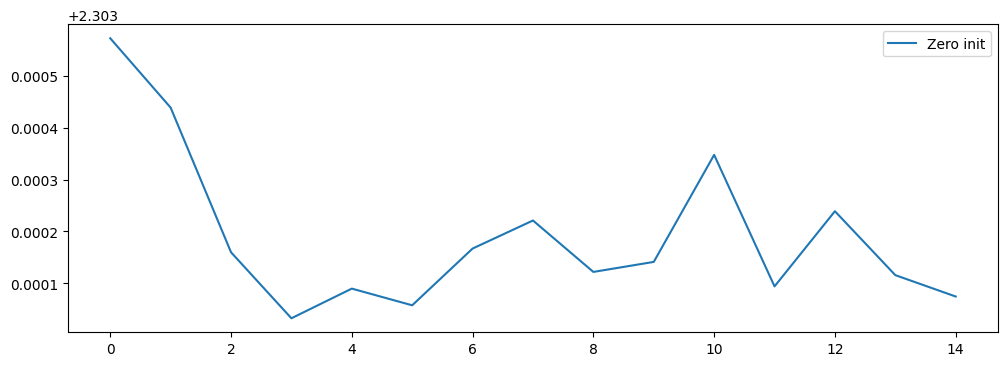

In [ ]:
# Training the model for 15 epochs using the fit method and plots the training loss over epochs.
history = model.fit(X_train, y_train, epochs=15, batch_size=32)

plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label="Zero init")
plt.legend();

In [ ]:
# Summary of Initialization Experiment Observations and Explanations:
# 1. Original SGD (default learning rate 0.01, Glorot Uniform-like initialization):
#    - Observations: Achieved good accuracy (~93.33%) and the loss decreased steadily.
#    - Explanation: Glorot Uniform initialization is designed to keep the variance of activations and gradients consistent across layers, which helps prevent vanishing or exploding gradients and promotes stable training with SGD.

# 2. SGD with decreased learning rate (0.001):
#    - Observations: Accuracy dropped significantly (~66.39%), and the loss decreased very slowly.
#    - Explanation: A very small learning rate causes the optimizer to take tiny steps in the parameter space, leading to very slow convergence. It might get stuck in a suboptimal local minimum within the given number of epochs.

# 3. SGD with increased learning rate (0.1):
#    - Observations: Accuracy was low (~42.50%), and the loss was erratic or diverged.
#    - Explanation: A large learning rate causes the optimizer to take large steps, potentially overshooting the minimum of the loss function. This can lead to oscillations or divergence, where the loss increases instead of decreases.

# 4. SGD with momentum (learning rate 0.01, momentum 0.9):
#    - Observations: Accuracy improved (~95.00%) compared to basic SGD, and the loss decreased more smoothly.
#    - Explanation: Momentum helps accelerate SGD in the relevant direction and dampens oscillations. It allows the optimizer to build up speed in directions with consistent gradients, leading to faster and sometimes better convergence, even with the default learning rate.

# 5. Adam optimizer (default settings):
#    - Observations: Accuracy reached a good level (~95.00%), similar to SGD with momentum, and the loss decreased efficiently.
#    - Explanation: Adam is an adaptive optimizer that adjusts the learning rate for each parameter based on the first and second moments of the gradients. This often leads to faster convergence and can handle different scales of gradients across parameters without extensive manual tuning.

# 6. Adam optimizer with an extra hidden layer:
#    - Observations: Accuracy slightly improved (~95.56%), and the loss was slightly lower.
#    - Explanation: Adding more layers can increase the model's capacity to learn more complex patterns in the data. With a suitable optimizer like Adam, this increased capacity can translate to better performance, provided the added complexity doesn't lead to overfitting (which wasn't significantly observed in this limited experiment).

# 7. Truncated Normal initialization with stddev=1e-3 (trained with SGD):
#    - Observations: Training was very slow initially, with gradual improvement in loss and accuracy over epochs. Accuracy reached around 60% after 15 epochs.
#    - Explanation: Very small initial weights can lead to vanishing gradients, especially with activation functions like tanh. The gradients become very small during backpropagation, making it difficult for the network to learn effectively in the early stages. Training eventually progresses, but it's significantly slower than with better initialization.

# 8. Truncated Normal initialization with stddev=1.0 (trained with SGD):
#    - Observations: Initial loss was high but decreased progressively. Accuracy improved steadily over epochs.
#    - Explanation: A larger standard deviation can lead to larger initial weights. This can push the outputs of activation functions (like tanh) into saturated regions, where the gradient is close to zero. While not as severe as with stddev=10.0, it can still slow down training compared to well-tuned initializations like Glorot.

# 9. Truncated Normal initialization with stddev=10.0 (trained with SGD):
#    - Observations: Very high initial loss, slow and erratic convergence, and low accuracy (~17-18%).
#    - Explanation: Extremely large initial weights can cause exploding gradients, where the gradients become very large during backpropagation, leading to unstable training and divergence. It can also severely saturate activation functions, making learning very difficult.

# 10. Zero initialization (trained with SGD):
#     - Observations: Loss remained constant around 2.302, and accuracy stayed at 10% (random guessing).
#     - Explanation: Initializing all weights to zero means that all neurons in a given layer will have the same output for a given input. During backpropagation, they will all receive the same gradient, and thus all weights will be updated identically. This prevents the neurons from learning different features, breaking the symmetry required for the network to learn effectively.

# Conclusion:
# Appropriate weight initialization is crucial for training deep neural networks. Poor initialization (too small, too large, or zero) can lead to problems like vanishing/exploding gradients and symmetry breaking, hindering the training process and resulting in poor performance. Advanced optimizers like Adam or SGD with momentum can be more robust to suboptimal initializations compared to basic SGD, but good initialization still plays a significant role in achieving faster convergence and better final performance.

### Advanced solvers (SGD with momenturm or Adam) optimizers.

Epoch 1/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.1180 - loss: 2.3011 - val_accuracy: 0.1076 - val_loss: 2.3042
Epoch 2/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1112 - loss: 2.3017 - val_accuracy: 0.1076 - val_loss: 2.3046
Epoch 3/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1103 - loss: 2.3017 - val_accuracy: 0.1076 - val_loss: 2.3049
Epoch 4/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0844 - loss: 2.3022 - val_accuracy: 0.1076 - val_loss: 2.3055
Epoch 5/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1015 - loss: 2.3019 - val_accuracy: 0.1076 - val_loss: 2.3054
Epoch 6/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1196 - loss: 2.2996 - val_accuracy: 0.1076 - val_loss: 2.3058
Epoch 7/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1097 - loss: 2.3028 - val_accuracy: 0.1076 - val_loss: 2.3060
Epoch 8/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1042 - loss: 2.3004 - val_accuracy: 0.1076 - val_loss

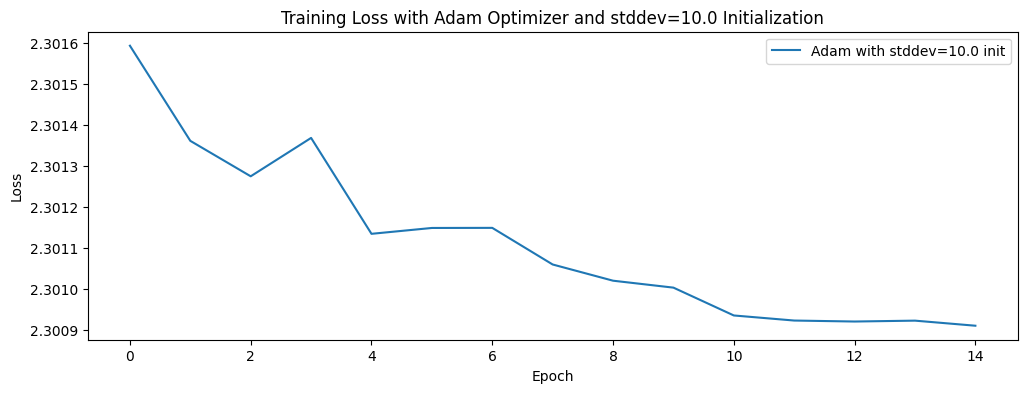

In [ ]:
from tensorflow.keras.optimizers import Adam

# Modifying the optimizer in this cell to use Adam()
model.compile(
    loss='categorical_crossentropy',    # Loss function
    optimizer=Adam(),                   # Optimizer
    metrics=['accuracy']                # Metrics to evaluate the model
)

# Training the model
history_adam = model.fit(
    X_train,                            # Training data
    y_train,                            # Training labels
    epochs=15,                          # Number of epochs
    batch_size=32,                      # Number of samples per batch
    validation_split=0.2                # Use 20% of the data for validation
)

plt.figure(figsize=(12, 4))
plt.plot(history_adam.history['loss'], label="Adam")
plt.legend();
plt.title("Training Loss with Adam Optimizer")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

Epoch 1/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.0999 - loss: 2.3038 - val_accuracy: 0.1076 - val_loss: 2.3078
Epoch 2/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0977 - loss: 2.3022 - val_accuracy: 0.0833 - val_loss: 2.3093
Epoch 3/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0935 - loss: 2.2995 - val_accuracy: 0.1076 - val_loss: 2.3088
Epoch 4/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0951 - loss: 2.3017 - val_accuracy: 0.1076 - val_loss: 2.3094
Epoch 5/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1009 - loss: 2.3024 - val_accuracy: 0.1076 - val_loss: 2.3093
Epoch 6/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1079 - loss: 2.2989 - val_accuracy: 0.1076 - val_loss: 2.3098
Epoch 7/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1049 - loss: 2.3009 - val_accuracy: 0.0833 - val_loss: 2.3100
Epoch 8/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1002 - loss: 2.3027 - val_accuracy: 0.1076 - val_loss

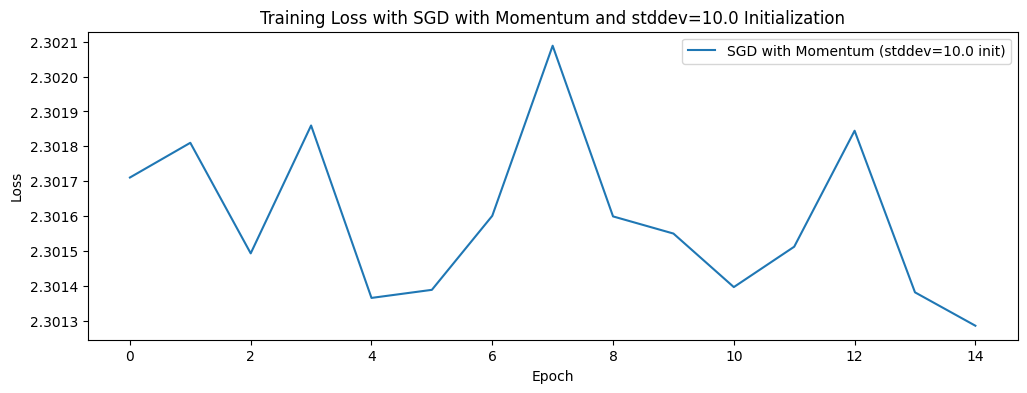

In [ ]:
from tensorflow.keras.optimizers import SGD

# Modifying the optimizer in the compilation cell to use SGD with momentum
model.compile(
    loss='categorical_crossentropy',                  # Loss function
    optimizer=SGD(learning_rate=0.01, momentum=0.9),  # Optimizer with momentum
    metrics=['accuracy']                              # Metrics to evaluate the model
)

# Training the model
history_sgd_momentum = model.fit(
    X_train,                                          # Training data
    y_train,                                          # Training labels
    epochs=15,                                        # Number of epochs
    batch_size=32,                                    # Number of samples per batch
    validation_split=0.2                              # Use 20% of the data for validation
)

plt.figure(figsize=(12, 4))
plt.plot(history_sgd_momentum.history['loss'], label="SGD with Momentum (stddev=0.01 init)")
plt.legend();
plt.title("Training Loss with SGD with Momentum and stddev=0.01 Initialization")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### Summary:
*   When using SGD with a small standard deviation (stddev=1e-3) for `TruncatedNormal` initialization, training was initially slow, but the loss gradually decreased, and accuracy improved over 15 epochs, reaching around 60%. This suggests that very small initial weights can lead to vanishing gradients, slowing down learning.
*   With a moderate standard deviation (stddev=1.0), the initial loss was high but decreased progressively, and accuracy improved steadily. This indicates that while larger weights can push activations into saturated regions, the effect is less severe than with very large standard deviations.
*   A large standard deviation (stddev=10.0) resulted in a very high initial loss, slow and erratic convergence, and low accuracy (around 17-18%). This is likely due to exploding gradients and severe saturation of activation functions.
*   Zero initialization led to a constant loss of approximately 2.302 and an accuracy of 10% (random guessing), indicating that the model failed to learn. This is because zero initialization prevents symmetry breaking, causing all neurons in a layer to learn the same features.
*   Neither the Adam optimizer nor SGD with momentum significantly improved training performance when the model was initialized with a large standard deviation (stddev=10.0) within 15 epochs. The loss remained high and stagnant, and accuracy stayed low, similar to basic SGD.

### Insights or Next Steps

*   Appropriate weight initialization is crucial for successful neural network training, even when using advanced optimizers. Poor initialization can lead to fundamental issues like vanishing/exploding gradients and lack of symmetry breaking that hinder learning.
*   Further investigation could involve training the poorly initialized models with advanced optimizers for a significantly larger number of epochs or experimenting with different learning rates and hyperparameters for the optimizers to see if they can eventually overcome the initial handicap.
